In [1]:
import casadi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

### パラメータ設定

In [2]:
ρ = 1025.0  # 海水密度

nabla = 0.2358  # 排水量[m3] Lpp*B:d*Cb
L_pp = 3.50  # 船長Lpp[m]
B = 0.57  # 船幅[m]
d = 0.16  # 喫水[m]
x_G = 0.0112  # 重心位置[]
C_b = 0.7390 # 方形係数
D_p = 0.03373 * L_pp #0.120  # プロペラ直径[m]
m = 1025 * nabla  # 質量(無次元化)[kg]
A_R = 0.0189  # 船の断面に対する舵面積比[-]
# H_R = 0.1495  # 舵高さ[m]
η = 0.8023  # プロペラ直径に対する舵高さ(Dp/H)
m_x_dash = 0.0475 # 付加質量x(無次元) kg/m3 * m2 * m /kg
m_y_dash = 0.6739 # 付加質量y(無次元)
J_z_dash = 0.0306 # 付加質量Izz(無次元)
f_α = 2.634 # 直圧力勾配係数
ϵ = 1.345  # プロペラ・舵位置伴流係数比
t_R = 0.084  # 操縦抵抗減少率 
a_H = 0.054  # 舵力増加係数
x_H = -0.388 * L_pp  # 舵力増分作用位置
γ_R_minus = 0.225 # 整流係数
γ_R_plus = 0.574  # 整流係数
l_r_dash = -0.641  # 船長に対する舵位置
κ = 0.482  # 修正係数
t_P = 0.035  # 推力減少率 #モデルの違い
w_P0 = 0.397  # 有効伴流率 #モデルの違い
# t_P = 0.180  # 推力減少率 #モデルの違い
# w_P0 = 0.40  # 有効伴流率 #モデルの違い
x_P = -0.490  # 船長に対するプロペラ位置 #モデルの違い
x_R = -0.500 * L_pp
I_zG=ρ * nabla * ((0.25 * L_pp) ** 2)
m_x=(0.5 * ρ * (L_pp ** 2) * d) * m_x_dash  # 付加質量x(無次元)
m_y=(0.5 * ρ * (L_pp ** 2) * d) * m_y_dash  # 付加質量y(無次元)
J_z=(0.5 * ρ * (L_pp ** 4) * d) * J_z_dash  # 付加質量Izz(無次元)

In [3]:
k_0 = 0.3516
k_1 = -0.3624
k_2 = -0.1100
R_0_dash = 0.020
X_vv_dash = -0.07993
X_vr_dash = 0.10163
X_rr_dash = -0.01487
X_vvvv_dash = 0.57037
Y_v_dash = -0.37112
Y_r_dash = 0.07203
# Y_v_dash = -0.3384 #-0.37112
# Y_r_dash = 0.1976 #0.07203
Y_vvv_dash = -1.05345
Y_vvr_dash = 0.20726
Y_vrr_dash = -0.25560
Y_rrr_dash = 0.02196
N_v_dash = -0.10969
N_r_dash = -0.04994
# N_v_dash = -0.1377 #-0.10969
# N_r_dash = -0.0992#-0.04994
N_vvv_dash = -0.05329
N_vvr_dash = -0.28770
N_vrr_dash = -0.02059
N_rrr_dash = -0.01959

In [4]:
def X_H(u,v,r):
    U=np.sqrt(u**2+v**2)
    β=np.arctan(-v/u)
    r_dash=r*L_pp/U
    v_dash=v/U
    return 0.5*ρ*L_pp*d*U**2*X_H_dash(v_dash,r_dash)

def Y_H(u,v,r):
    U=np.sqrt(u**2+v**2)
    β=np.arctan(-v/u)
    r_dash=r*L_pp/U
    v_dash=v/U
    return 0.5*ρ*L_pp*d*U**2*Y_H_dash(v_dash,r_dash)

def N_H(u,v,r):
    U=np.sqrt(u**2+v**2)
    β=np.arctan(-v/u)
    r_dash=r*L_pp/U
    v_dash=v/U
    return 0.5*ρ*L_pp**2*d*U**2*N_H_dash(v_dash,r_dash)

def X_H_dash(β,r_dash):
    return -R_0_dash+X_vv_dash*β**2+X_vr_dash*β*r_dash+X_rr_dash*r_dash**2+X_vvvv_dash*β**4

def Y_H_dash(β,r_dash):
    return Y_v_dash*β+Y_r_dash*r_dash+Y_vvr_dash*β**2*r_dash+Y_vrr_dash*β*r_dash**2+Y_vvv_dash*β**3+Y_rrr_dash*r_dash**3

def N_H_dash(β,r_dash):
    return N_v_dash*β+N_r_dash*r_dash+N_vvr_dash*β**2*r_dash+N_vrr_dash*β*r_dash**2+N_vvv_dash*β**3+N_rrr_dash*r_dash**3

def X_R(u,v,r,δ,n_p):
    return -(1-t_R)*F_N(u,v,r,δ,n_p)*np.sin(δ)

def Y_R(u,v,r,δ,n_p):
    return -(1+a_H)*F_N(u,v,r,δ,n_p)*np.cos(δ)

def N_R(u,v,r,δ,n_p):
    return -(x_R+a_H*x_H)*F_N(u,v,r,δ,n_p)*np.cos(δ)

def F_N(u,v,r,δ,n_p):
    U=np.sqrt(u**2+v**2)
    β=np.arctan(-v/U)
    r_dash=r*L_pp/U
    w_P = w_P0 * np.exp(-4.0 * (β - x_P * r_dash) ** 2)
    u_p=(1-w_P)*u
    u_R=ϵ*u_p*np.sqrt(η*(1+κ*(np.sqrt(1+(8*K_T(u,v,r,n_p))/(np.pi*J(u,v,r,n_p)**2))-1))**2+(1-η))
    v_R=U*γ_R_plus*(β-l_r_dash*r_dash)
    α_R=δ-np.arctan(v_R/u_R)
    U_R=np.sqrt(u_R**2+v_R**2)
    return 0.5*ρ*A_R*U_R**2*f_α*np.sin(α_R)

def X_P(u,v,r,δ,n_p):
    return (1-t_P)*T_P(u,v,r,n_p)

def K_T(u,v,r,n_p):
    return k_0+k_1*J(u,v,r,n_p)+k_2*J(u,v,r,n_p)**2

def J(u,v,r,n_p):
    U=np.sqrt(u**2+v**2)
    β=np.arctan(-v/U)
    r_dash=r*L_pp/U
    w_P = w_P0 * np.exp(-4.0 * (β - x_P * r_dash) ** 2)
    return u*(1-w_P)/(n_p*D_p)

def T_P(u,v,r,n_p):
    return K_T(u,v,r,n_p)*ρ*n_p**2*D_p**4

In [5]:
# 目標軌道の設定
obs = pd.read_csv('suzaku_obs.csv')
obs

,Unnamed: 0,time_list,u,v,r,x,y,psi,δ,npm,...,X_R_ref,X_P_ref,Y_H_ref,Y_R_ref,N_H_ref,N_R_ref,x_bow,y_bow,x_stern,y_stern
0,0,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.349066,9,...,-6.012895,-3.135306,0.000000,-16.520294,-0.000000,32.884258,1.750000,0.000000,-1.750000,0.000000
1,1,0.200200,1.978094,-0.003999,0.010904,0.398198,-0.000241,0.001118,0.349066,9,...,-5.724828,-3.020870,2.403583,-15.728835,-2.915959,31.308830,2.148197,0.001715,-1.351801,-0.002197
2,2,0.400400,1.956725,-0.008478,0.020361,0.792067,-0.000485,0.004269,0.349066,9,...,-5.467646,-2.916099,4.652658,-15.022235,-5.171430,29.902316,2.542052,0.006986,-0.957917,-0.007956
3,3,0.600601,1.935799,-0.013307,0.028636,1.181709,-0.000095,0.009192,0.349066,9,...,-5.235498,-2.819013,6.763967,-14.384413,-6.906026,28.632708,2.931635,0.015991,-0.568217,-0.016180
4,4,0.800801,1.915231,-0.018389,0.035938,1.567202,0.001480,0.015670,0.349066,9,...,-5.023859,-2.728112,8.751844,-13.802940,-8.228273,27.475265,3.316987,0.028902,-0.182584,-0.025942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,199.199199,0.110315,-0.027617,0.063344,10.119379,16.891988,12.316021,0.349066,9,...,-0.619593,4.868432,2.478541,-1.702318,-2.975548,3.388527,11.814824,16.458438,8.423934,17.325539
996,996,199.399399,0.111760,-0.027809,0.063502,10.139571,16.881344,12.328712,0.349066,9,...,-0.619820,4.860373,2.490218,-1.702942,-2.980048,3.389770,11.840382,16.469345,8.438760,17.293343
997,997,199.599600,0.113119,-0.027935,0.063656,10.160175,16.870821,12.341437,0.349066,9,...,-0.620153,4.852794,2.498817,-1.703857,-2.984853,3.391591,11.866090,16.480498,8.454259,17.261144
998,998,199.799800,0.114369,-0.027970,0.063807,10.181188,16.860429,12.354196,0.349066,9,...,-0.620628,4.845830,2.503128,-1.705161,-2.990010,3.394186,11.891945,16.491902,8.470431,17.228955


In [6]:
# 評価関数の重み
Q = casadi.diag([1,1,1,1]) # 状態変数の重み
Q_f = casadi.diag([1,1,1,1])
R = casadi.diag([1e-2,1e-2,1e-3]) # 制御入力の重み

# ホライゾン
K = 50
T = 130
dt = 0.2

# 制約条件
x_lb = [-np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf]
x_ub = [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]
u_lb = [-10, -10, -10]
u_ub = [10, 10, 10]

nx = 8 # 状態変数の次元
nu = 3 # 制御入力の次元

# 目標値
x_ref = casadi.DM(obs[['x_bow', 'y_bow', 'x_stern', 'y_stern']].values)
# u_ref = casadi.DM() 設定しない

# 最適化に現れる全ての変数の次元の合計
total = nx*(K+1) + nu*K

In [7]:
total

558

### 状態方程式の設定

In [8]:
# states:u,v,r,x1,y1,x2,y2,psi,δ,np
# ctrls:xf,yf,nf

In [9]:
def make_f():
    states = casadi.SX.sym('states', nx)
    ctrls = casadi.SX.sym('ctrls', nu)
    # 状態変数
    u = states[0]
    v = states[1]
    r = states[2]
    x_bow = states[3]
    y_bow = states[4]
    x_stern = states[5]
    y_stern = states[6]
    psi = states[7]
    # δ = states[8]
    # np = states[9]
    δ = obs['δ'][0]
    np = obs['npm'][0]
    # 制御入力
    X_F = ctrls[0]
    Y_F = ctrls[1]
    N_F = ctrls[2]
    
    u_dot = (X_H(u,v,r)+X_R(u,v,r,δ,np)+X_P(u,v,r,δ,np)+X_F+(m+m_y)*v*r)/(m+m_x)
    v_dot = (Y_H(u,v,r)+Y_R(u,v,r,δ,np)+Y_F-(m+m_x)*u*r)/(m+m_y)
    r_dot = (N_H(u,v,r)+N_R(u,v,r,δ,np)+N_F)/(I_zG+J_z)
    x_bow_dot = u*casadi.cos(psi)-v*casadi.sin(psi)-0.5*L_pp*r*casadi.sin(psi)
    y_bow_dot = u*casadi.sin(psi)+v*casadi.cos(psi)+0.5*L_pp*r*casadi.cos(psi)
    x_stern_dot = u*casadi.cos(psi)-v*casadi.sin(psi)+0.5*L_pp*r*casadi.sin(psi)
    y_stern_dot = u*casadi.sin(psi)+v*casadi.cos(psi)-0.5*L_pp*r*casadi.cos(psi)
    psi_dot = r
    
    # states_dot = casadi.vertcat(x_bow_dot, y_bow_dot, x_stern_dot, y_stern_dot, u_dot, v_dot, r_dot, psi_dot)
    states_dot = casadi.vertcat(u_dot, v_dot, r_dot, x_bow_dot, y_bow_dot, x_stern_dot, y_stern_dot, psi_dot)
    
    f = casadi.Function('f',[states,ctrls],[states_dot],
                        ['x','u'],['x_dot'])
    return f

In [10]:
x_ref[1,0:4]

DM([[2.1482, 0.00171539, -1.3518, -0.00219686]])

### 連続時間状態方程式の時間離散化

In [11]:
def make_RK4():
    states = casadi.SX.sym('states',nx) # nxの数を設定
    ctrls = casadi.SX.sym('ctrls',nu)
    
    f = make_f()
    
    r1 = f(x=states,u=ctrls)['x_dot']
    r2 = f(x=states+dt*r1/2,u=ctrls)['x_dot']
    r3 = f(x=states+dt*r2/2,u=ctrls)['x_dot']
    r4 = f(x=states+dt*r3,u=ctrls)['x_dot']
    
    states_next = states + dt*(r1+2*r2+2*r3+r4)/6
    
    RK4 = casadi.Function('RK4',[states,ctrls],[states_next],
                          ['x','u'],['x_next'])
    return RK4

### 積分器の作成

In [12]:
def make_integrator():
    states = casadi.SX.sym('states',nx)
    ctrls = casadi.SX.sym('ctrls',nu)
    
    f = make_f()
    ode = f(x=states,u=ctrls)['x_dot']
    
    dae = {'x':states,'p':ctrls,'ode':ode}
    
    I = casadi.integrator('I','cvodes',dae,0,dt)
    return I

### 評価関数

In [13]:
def compute_stage_cost(x,u,k):
    x_extract = x[3:7]
    x_diff = x_extract - x_ref[k,:].T
    # u_refは設定しないためu_diffはなし
    cost = (casadi.dot(Q@x_diff,x_diff)
            + casadi.dot(R@u,u)) / 2
    return cost

def compute_terminal_cost(x):
    x_extract = x[3:7]
    x_diff = x_extract - x_ref[-1,:].T
    cost = casadi.dot(Q_f@x_diff,x_diff) / 2
    return cost

### 最適化問題の定式化

In [14]:
X = [casadi.SX.sym(f'x_{k}',nx) for k in range(K+1)]
A = X[0]
A[3:7]

SX([x_0_3, x_0_4, x_0_5, x_0_6])

In [15]:
def make_nlp():
    RK4 = make_RK4()
    U = [casadi.SX.sym(f'u_{k}',nu) for k in range(K)]
    X = [casadi.SX.sym(f'x_{k}',nx) for k in range(K+1)]
    G = []
    
    J = 0
    
    for k in range(K):
        J += compute_stage_cost(X[k],U[k],k)*dt #評価関数はC
        eq = X[k+1] - RK4(x=X[k],u=U[k])['x_next']
        G.append(eq) # 制約条件を追加
    J += compute_terminal_cost(X[-1])
    
    option = {'print_time':False,
              'ipopt':{'max_iter':10,'print_level':0}}
    # nlp = {'x':casadi.vertcat(*X,*U),'f':J,'g':casadi.vertcat(*G)}
    nlp = {
        'x': casadi.vertcat(*[X[k] for k in range(K+1)], *[U[k] for k in range(K)]),
        'f': J,
        'g': casadi.vertcat(*G)
    }
    S = casadi.nlpsol('S','ipopt',nlp,option)
    return S

### 最適な制御入力を出力する関数

In [16]:
def compute_optimal_control(S,x_init,x0):
    x_init = x_init.full().ravel().tolist()
    
    lbx = x_init + x_lb*K + u_lb*K
    ubx = x_init + x_ub*K + u_ub*K
    lbg = [0]*nx*K
    ubg = [0]*nx*K
    
    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    offset = nx*(K+1)
    x0 = res['x']
    u_opt = x0[offset:offset+nu]
    return u_opt, x0

In [17]:
# x_init = casadi.DM([obs['u'][0],obs['v'][0],obs['r'][0],obs['x_bow'][0], obs['y_bow'][0], obs['x_stern'][0], obs['y_stern'][0],obs['psi'][0]])
# x_init = x_init.full().ravel().tolist()
# lbx = x_init + x_lb*K + u_lb*K
# np.shape(lbx)

### MPCの実行

In [18]:
t_span = [0,130]
t_eval = np.arange(*t_span,dt)

x_init = casadi.DM([obs['u'][0],obs['v'][0],obs['r'][0],obs['x_bow'][0], obs['y_bow'][0], obs['x_stern'][0], obs['y_stern'][0],obs['psi'][0]])
x0 = casadi.DM.zeros(total)

S = make_nlp()
I = make_integrator()

X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    u_opt,x0 = compute_optimal_control(S,x_current,x0)
    x_current = I(x0=x_current,p=u_opt)['xf']
    X.append(x_current)
    U.append(u_opt)
    
X.pop()
X = np.array(X).reshape(t_eval.size,nx)
U = np.array(U).reshape(t_eval.size,nu)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



CasADi - 2024-10-02 14:14:45 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 34 (row 8, col 8).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-02 14:14:45 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 34 (row 8, col 8).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-02 14:14:45 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 34 (row 8, col 8).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-02 14:14:45 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 34 (row 8, col 8).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-02 14:14:45 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 34 (row 8, col 8).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-10-02 14:14:45 WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 34 (row 8, col 8).") [.../casadi/core

### 結果の可視化

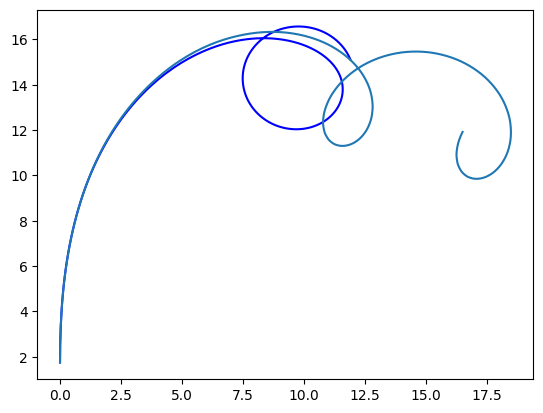

In [19]:
u_ref, v_ref, r_ref, x_bow_ref, y_bow_ref, x_stern_ref, y_stern_ref, psi_ref = obs[['u', 'v', 'r', 'x_bow', 'y_bow', 'x_stern', 'y_stern', 'psi']].values.T
u, v, r, x_bow, y_bow, x_stern, y_stern, psi = X.T
X_F, Y_F, N_F = U.T
plt.plot(y_bow, x_bow, c='b')
plt.plot(y_bow_ref, x_bow_ref)


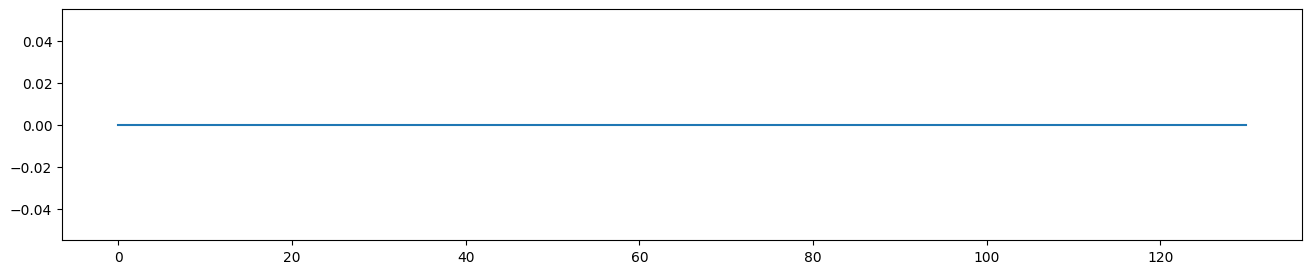

In [20]:
plt.figure(figsize=(16,3))
plt.plot(t_eval, N_F)